Main objective is to fine tune the llm model to handle extra data inside the input provided by the application. <br> 1. Take a question answering dataset. <br> 2. Convert question-answers into triplets. <br> 3. Fine tune llm on the questions with also providing the correct triplets. <br>
Good example for dataset: Databricks-dolly-15k https://huggingface.co/datasets/databricks/databricks-dolly-15k?row=6 <br>

In [1]:
!pip install datasets
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.0 MB/s eta 0:00:00


In [47]:
!git config --global credential.helper store
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid (permission: read).
Your token has been saved in your conf

In [49]:
from datasets import load_dataset
from transformers import pipeline
import random
import requests
import matplotlib.pyplot as plt

### Load model

In [12]:
triplet_extractor = pipeline('text2text-generation', model='Babelscape/rebel-large', tokenizer='Babelscape/rebel-large')
# Function to parse the generated text and extract the triplets
def extract_triplets(text):
    triplets = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    for token in text.replace("<s>", "").replace("<pad>", "").replace("</s>", "").split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
    return triplets


config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/344 [00:00<?, ?B/s]

<s><triplet> Punta Cana <subj> La Altagracia Province <obj> located in the administrative territorial entity <subj> Dominican Republic <obj> country <triplet> Higuey <subj> La Altagracia Province <obj> located in the administrative territorial entity <subj> Dominican Republic <obj> country <triplet> La Altagracia Province <subj> Dominican Republic <obj> country <triplet> Dominican Republic <subj> La Altagracia Province <obj> contains administrative territorial entity</s>
[{'head': 'Punta Cana', 'type': 'located in the administrative territorial entity', 'tail': 'La Altagracia Province'}, {'head': 'Punta Cana', 'type': 'country', 'tail': 'Dominican Republic'}, {'head': 'Higuey', 'type': 'located in the administrative territorial entity', 'tail': 'La Altagracia Province'}, {'head': 'Higuey', 'type': 'country', 'tail': 'Dominican Republic'}, {'head': 'La Altagracia Province', 'type': 'country', 'tail': 'Dominican Republic'}, {'head': 'Dominican Republic', 'type': 'contains administrative 

In [14]:
def transform_text_to_string_of_triplets(text):
  extracted_text = triplet_extractor.tokenizer.batch_decode([triplet_extractor(text, return_tensors=True, return_text=False)[0]["generated_token_ids"]])
  extracted_triplets = extract_triplets(extracted_text[0])
  return "\n".join([f"{trip['head']}|{trip['type']}|{trip['tail']}" for trip in extracted_triplets])


In [17]:
out = transform_text_to_string_of_triplets("Napoleon Bonaparte (born Napoleone di Buonaparte;[1][b] 15 August 1769 – 5 May 1821), later known by his regnal name Napoleon I, was a French emperor and military commander who rose to prominence during the French Revolution and led successful campaigns during the Revolutionary Wars. He was the leader of the French Republic as First Consul from 1799 to 1804, then of the French Empire as Emperor of the French from 1804 until 1814, and briefly again in 1815. His political and cultural legacy endures as a celebrated and controversial leader. He initiated many enduring reforms, but has been criticized for his authoritarian rule. He is considered one of the greatest military commanders in history and his wars and campaigns are still studied at military schools worldwide. However, historians still debate the degree to which he was responsible for the Napoleonic Wars, in which between three and six million people died.[2][3]")
print(out)

Napoleon Bonaparte|date of birth|15 August 1769
Napoleon Bonaparte|date of death|5 May 1821
Napoleon Bonaparte|participant in|French Revolution
Napoleon Bonaparte|conflict|Revolutionary Wars
French Revolution|participant|Napoleon Bonaparte
Revolutionary Wars|participant|Napoleon Bonaparte


# Create dataset

In [18]:
dataset = load_dataset("databricks/databricks-dolly-15k")
filtered_dataset = dataset['train'].filter(lambda example: example['category'] in ["closed_qa", "information_extraction", "summarization"])

4467
{'instruction': 'What are the names of the general purpose registers in the x86-64 architecture?', 'context': 'In addition to increasing the size of the general-purpose registers, the number of named general-purpose registers is increased from eight (i.e. eax, ecx, edx, ebx, esp, ebp, esi, edi) in x86 to 16 (i.e. rax, rcx, rdx, rbx, rsp, rbp, rsi, rdi, r8, r9, r10, r11, r12, r13, r14, r15). It is therefore possible to keep more local variables in registers rather than on the stack, and to let registers hold frequently accessed constants; arguments for small and fast subroutines may also be passed in registers to a greater extent.', 'response': 'The x86-64 architecture has 16 general purpose registers. They are named rax, rcx, rdx, rbx, rsp, rbp, rsi, rdi, r8, r9, r10, r11, r12, r13, r14, and r15.', 'category': 'information_extraction'}


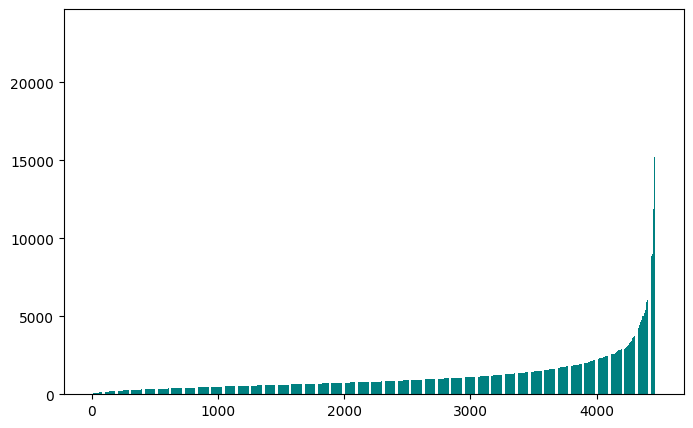

In [36]:
print(filtered_dataset.num_rows)
print(filtered_dataset.select([random.randint(0, len(filtered_dataset) - 1)])[0])
lengths = sorted([len(text) for text in filtered_dataset['context']])

plt.figure(figsize=(8, 5))
plt.bar(range(len(lengths)), lengths, color='teal')
plt.show()

In [38]:
SELECT_N_ROWS = 100
CONTEXT_CHAR_LIMIT = 3000

print(f"Length before dropping anything: {filtered_dataset.num_rows}")
small_filtered_dataset = filtered_dataset.filter(lambda x : len(x['context']) < CONTEXT_CHAR_LIMIT)
length = small_filtered_dataset.num_rows
print(f"New size after dropping too long contextes: {length}")
small_filtered_dataset = small_filtered_dataset.select(random.sample(range(length), SELECT_N_ROWS))
print(f"New size after random selection: {small_filtered_dataset.num_rows}")

small_filtered_dataset = small_filtered_dataset.map(lambda x : {'context': transform_text_to_string_of_triplets(x['context'])} )

Length before dropping anything: 4467
New size after dropping too long contextes: 4232
New size after random selection: 100


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [43]:
final_dataset = small_filtered_dataset.map(lambda x : {'input': x['context'] + "\n" + x['instruction'],
                                                       'output': x['response']})

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [54]:
final_dataset.push_to_hub("rPucs/TripletDollyQA-0.1",
                          private=False,
                          commit_description="Test upload of the progmatically created TripletDollyQA dataset",
                          token="")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/rPucs/TripletDollyQA-0.1/commit/11ab28a6b7aeddd9739be0ea8d54c15513ed958e', commit_message='Upload dataset', commit_description='Test upload of the progmatically created TripletDollyQA dataset', oid='11ab28a6b7aeddd9739be0ea8d54c15513ed958e', pr_url=None, pr_revision=None, pr_num=None)